Summary

Inputs: Observed and simulated reservoir data + meteorological variables. Daily data 10 years.
Outputs: storage uptil 30 days, 60 days, 90 days ahead

Model : Long-Short Term Memory (We also tried Dense networks, LSTMS, WaveNets)

Interesting facts on the model: 
-  Monte-Carlo Ensemble Model :https://arxiv.org/abs/1506.02142
-  Cyclical Learning Rate + Learning Rate Finder (also experimented with power scheduling)
-  Hyperparameter Tuning: We tried 100s of combinations of Input Width, Number of Layers, batch_size, l1_reg, l2_reg, dropout rate
-  Reduce Overfitting: Early Stopping Patience, L1, L2 regularization, dropout
-  Mean Square Error Loss Function (also experimented with nash-sutcliffe loss, mean absolute error)

In [ ]:
# @Author: Sagar Garg

#HOW TO RUN
#0. Get files in the correct path in Mount Drive
#1. Change Configuration
#2. Run all blocks except (Ignore) blocks

In [ ]:
#To-Do: 
    #Add the correct evaluation metric. We only need MSE for last output. Build custom function. - Done
    #Add uncertainty estimates using Monte-Carlo Dropout - Done
    #In make_dataset, we put shuffle=True. Be careful! On test-set, put shuffle=False - Done
    #Try NSE Loss function - Done though NeuralHydrology paper tells it doesn't make much difference. we confirm experimentally the same - Done
    #for krs, include outflow from harangi and hemavati. for others, don't - Done
    #Get the correct date format - Done

In [1]:
#@title #####Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_path = '/content/gdrive/My Drive/Colab Notebooks/wave2web/'
%cd '/content/gdrive/My Drive/Colab Notebooks/wave2web/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/wave2web


In [2]:
# @title ####imports
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Configuration

In [399]:
#Data
DAM='krs' #@param ['harangi','kabini','krs','hemavathi']
#START_DATE='2013-06-11'
#END_DATE='2020-12-16'
LABEL_WIDTH =  90#@param #days to predict
INPUT_WIDTH =  120#@param #past input days
SHIFT =  30#@param # predict timesteps ahead
LABEL_WIDTH_DISPLAY =  40#@param #how many predictions to plot at once. The model still trains only on LABEL_WIDTH, this is for plotting
#for instance: train a model on 60 days data, predict output till 30 days ahead, show 20 such outputs at once in plot.

#Model
MAX_EPOCHS =  500#@param
PATIENCE =  25#@param # stops training if overfitting. dont set it too low.
BATCH_SIZE = 256 #@param

l1_reg=0.0001 #@param
l2_reg=0.0001 #@param
DROPOUT=0.2 #@param
RECURRENT_DROPOUT=0.2 #@param

#LSTM_HIDDEN_LAYERS = 3 #standard is 3 for short input width, 1 for long
#HIDDEN_SIZE=32


# Data Cleaning and Transformation

In [400]:
inputs=pd.read_csv(f'{DAM}_combined_db_storage.csv')
inputs

,date,storage,reservoir level,observed inflow,observed outflow,simulated inflow,simulated outflow,simulated precipitation,simulated evapotranspiration,simulated storage,precipitation,evapotranspiration,soil moisture,outflow hemavathi,outflw harangi
0,1/1/2011,46.42,122.59,57.46128,56.64000,294.2,349.6,5272.0,60910.0,23.350058,0.103059,0.565,123.0,56.66832,0.0
1,1/2/2011,46.54,122.68,87.33888,42.19680,230.9,215.6,0.0,113100.0,23.392435,0.000000,0.000,123.0,55.22400,0.0
2,1/3/2011,46.64,122.75,78.61632,42.22512,225.6,224.0,0.0,138900.0,23.392435,0.000000,0.000,123.0,55.22400,0.0
3,1/4/2011,46.69,122.79,65.44752,42.22512,195.3,193.7,0.0,137800.0,23.392435,0.000000,0.000,123.0,30.44400,0.0
4,1/5/2011,46.70,122.80,52.30704,42.22512,200.7,199.2,0.0,130300.0,23.392435,0.000000,0.000,123.0,15.57600,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,12/27/2020,NaN,NaN,NaN,NaN,153.6,152.1,0.0,130300.0,23.519568,0.000000,0.000,123.0,NaN,NaN
3649,12/28/2020,NaN,NaN,NaN,NaN,150.5,149.1,0.0,117200.0,23.519568,0.000000,0.000,123.0,NaN,NaN
3650,12/29/2020,NaN,NaN,NaN,NaN,146.9,145.6,0.0,117600.0,23.519568,0.000000,0.000,123.0,NaN,NaN
3651,12/30/2020,NaN,NaN,NaN,NaN,143.7,142.2,0.0,125000.0,23.519568,0.000000,0.000,123.0,NaN,NaN


In [401]:
inputs.info() #about 10% data missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          3653 non-null   object 
 1   storage                       3307 non-null   float64
 2   reservoir level               3306 non-null   float64
 3   observed inflow               3306 non-null   float64
 4   observed outflow              3307 non-null   float64
 5   simulated inflow              3653 non-null   float64
 6   simulated outflow             3653 non-null   float64
 7   simulated precipitation       3653 non-null   float64
 8   simulated evapotranspiration  3653 non-null   float64
 9   simulated storage             3653 non-null   float64
 10  precipitation                 3653 non-null   float64
 11  evapotranspiration            3653 non-null   float64
 12  soil moisture                 3653 non-null   float64
 13  out

In [402]:
inputs.describe()

,storage,reservoir level,observed inflow,observed outflow,simulated inflow,simulated outflow,simulated precipitation,simulated evapotranspiration,simulated storage,precipitation,evapotranspiration,soil moisture,outflow hemavathi,outflw harangi
count,3307.000000,3306.000000,3306.000000,3307.000000,3653.000000,3653.000000,3.653000e+03,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000,3308.000000,3464.000000
mean,28.048990,102.621945,139.237242,137.189650,311.566739,312.759005,1.787583e+05,75681.563321,18.926767,3.804885,0.846555,121.644128,70.978667,34.606106
std,14.356327,17.408030,302.994996,269.247328,375.074974,407.136665,3.742916e+05,52973.695268,7.177467,7.577868,0.932767,12.623630,116.790250,83.086369
min,0.000000,62.800000,0.000000,0.000000,1.590000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000
25%,14.295000,87.262500,9.034080,20.262960,75.280000,95.000000,0.000000e+00,34340.000000,17.445445,0.000000,0.000000,122.000000,5.664000,0.000000
50%,27.380000,105.450000,48.625440,104.868960,211.300000,172.000000,1.195000e+04,62630.000000,22.919219,0.425903,0.608000,123.000000,28.320000,1.982400
75%,42.090000,119.295000,153.961680,146.131200,425.300000,414.600000,1.973000e+05,119800.000000,23.434813,4.375793,1.320000,127.000000,123.192000,43.896000
max,49.450000,124.800000,5782.944000,4286.656800,5836.000000,5881.000000,5.139000e+06,247700.000000,23.519568,97.609635,5.170000,141.000000,2769.696000,2225.640480


In [403]:
#FEATURE ADDITION

#converting date to a better, smoother feature (since data has cyclic tendencies yearly, it is better to show that Dec-2015 is as similar to Jan-2016  as  March is to april)
#https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning
#To-do: Fast Fourier Transform to find correct frequencies


In [404]:
day=30.0
month=12.0

inputs['day']=pd.DatetimeIndex(inputs['date']).day
inputs['month']=pd.DatetimeIndex(inputs['date']).month
inputs['year']=pd.DatetimeIndex(inputs['date']).year

inputs['Day sin'] = np.sin(inputs['day'] * (2 * np.pi / day))
inputs['Day cos'] = np.cos(inputs['day'] * (2 * np.pi / day))
inputs['Month sin'] = np.sin(inputs['month'] * (2 * np.pi / month))
inputs['Month cos'] = np.cos(inputs['month'] * (2 * np.pi / month))

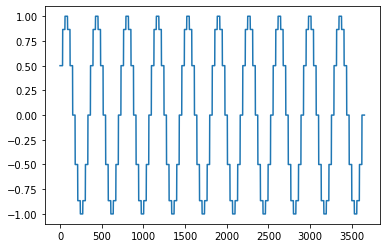

In [405]:
plt.plot(np.array(inputs['Month sin']))

In [406]:
#inputs_with_days=inputs # for later
inputs=inputs.drop(['date'],axis=1)

#inputs=inputs.drop(['day'],axis=1) #should drop
#inputs=inputs.drop(['month'],axis=1) # should drop

In [407]:
inputs.info(), inputs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   storage                       3307 non-null   float64
 1   reservoir level               3306 non-null   float64
 2   observed inflow               3306 non-null   float64
 3   observed outflow              3307 non-null   float64
 4   simulated inflow              3653 non-null   float64
 5   simulated outflow             3653 non-null   float64
 6   simulated precipitation       3653 non-null   float64
 7   simulated evapotranspiration  3653 non-null   float64
 8   simulated storage             3653 non-null   float64
 9   precipitation                 3653 non-null   float64
 10  evapotranspiration            3653 non-null   float64
 11  soil moisture                 3653 non-null   float64
 12  outflow hemavathi             3308 non-null   float64
 13  out

(None,            storage  reservoir level  ...     Month sin     Month cos
 count  3307.000000      3306.000000  ...  3.653000e+03  3.653000e+03
 mean     28.048990       102.621945  ... -4.665464e-03 -1.960102e-03
 std      14.356327        17.408030  ...  7.058802e-01  7.085064e-01
 min       0.000000        62.800000  ... -1.000000e+00 -1.000000e+00
 25%      14.295000        87.262500  ... -8.660254e-01 -8.660254e-01
 50%      27.380000       105.450000  ... -2.449294e-16 -1.836970e-16
 75%      42.090000       119.295000  ...  5.000000e-01  8.660254e-01
 max      49.450000       124.800000  ...  1.000000e+00  1.000000e+00
 
 [8 rows x 21 columns])

In [408]:
## A way to visualize trend and seasonality
# # Importing required libraries
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition
# result = seasonal_decompose(db_1['storage'], model ='multiplicative')
  
# # ETS plot 
# result.plot()

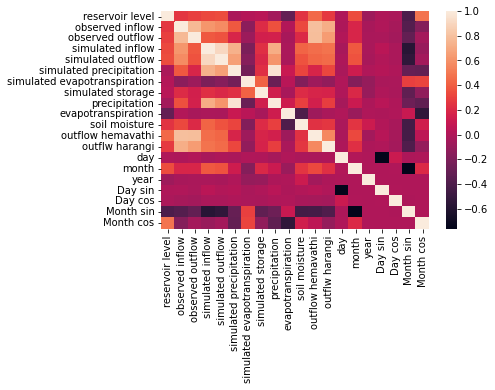

In [409]:
#FEATURE SELECTION
#Method 1: If 2 variables have high correlation, drop one of them
df=inputs.drop(['storage'], axis=1)
corr=df.corr()
sns.heatmap(corr)

In [410]:
#Method 2: Feature Importance via Random Forest

from sklearn.ensemble import RandomForestRegressor
df=inputs
df=df.dropna()
df2=df.drop(['storage'], axis=1)
#df2=df2.drop(['date'], axis=1)
df2=df2.drop(['reservoir level'], axis=1)
df=df.dropna()
df2=df2.dropna()
model = RandomForestRegressor(random_state=1, max_depth=10)
df2=pd.get_dummies(df2)
model.fit(df2,df.storage)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

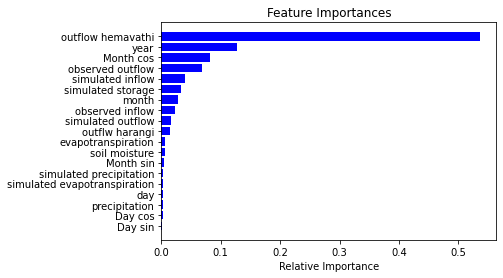

In [411]:
features = df2.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [412]:
## FEATURE SELECTION
inputs=inputs.drop(['reservoir level'], axis=1)

if DAM in ('krs'):
    inputs=inputs.drop(['precipitation'], axis=1)#
    inputs=inputs.drop(['simulated precipitation'], axis=1)#
    inputs=inputs.drop(['simulated evapotranspiration'], axis=1)#
    inputs=inputs.drop(['soil moisture'], axis=1)#
    inputs=inputs.drop(['evapotranspiration'], axis=1)#
    inputs=inputs.drop(['simulated outflow'], axis=1)#
    inputs=inputs.drop(['Day cos'], axis=1)#
    inputs=inputs.drop(['Day sin'], axis=1)#
    #inputs=inputs.drop(['observed outflow'], axis=1)
    #inputs=inputs.drop(['observed inflow'], axis=1)
    inputs=inputs.drop(['simulated storage'], axis=1)
    inputs=inputs.drop(['simulated inflow'], axis=1)
    inputs=inputs.drop(['Month sin'], axis=1)#
    inputs=inputs.drop(['outflw harangi'], axis=1)#
    
    
    
if DAM in ('harangi'):
    inputs=inputs.drop(['precipitation'], axis=1)
    inputs=inputs.drop(['simulated precipitation'], axis=1)
    inputs=inputs.drop(['simulated evapotranspiration'], axis=1)
    inputs=inputs.drop(['soil moisture'], axis=1)
    inputs=inputs.drop(['evapotranspiration'], axis=1)
    inputs=inputs.drop(['simulated outflow'], axis=1)
    inputs=inputs.drop(['Day cos'], axis=1)
    inputs=inputs.drop(['Day sin'], axis=1)
    inputs=inputs.drop(['observed outflow'], axis=1)
    inputs=inputs.drop(['simulated storage'], axis=1)
    
if DAM in ('kabini'):
    inputs=inputs.drop(['precipitation'], axis=1)#
    inputs=inputs.drop(['simulated precipitation'], axis=1)#
    inputs=inputs.drop(['simulated evapotranspiration'], axis=1)#
    inputs=inputs.drop(['soil moisture'], axis=1)#
    inputs=inputs.drop(['evapotranspiration'], axis=1)#
    inputs=inputs.drop(['simulated outflow'], axis=1)#
    inputs=inputs.drop(['Day cos'], axis=1)#
    inputs=inputs.drop(['Day sin'], axis=1)#
    #inputs=inputs.drop(['observed outflow'], axis=1)
    inputs=inputs.drop(['simulated storage'], axis=1)#
    

if DAM in ('hemavathi'):
    inputs=inputs.drop(['precipitation'], axis=1)#
    inputs=inputs.drop(['simulated precipitation'], axis=1)#
    inputs=inputs.drop(['simulated evapotranspiration'], axis=1)#
    inputs=inputs.drop(['soil moisture'], axis=1)#
    inputs=inputs.drop(['evapotranspiration'], axis=1)#
    inputs=inputs.drop(['simulated outflow'], axis=1)#
    inputs=inputs.drop(['Day cos'], axis=1)#
    inputs=inputs.drop(['Day sin'], axis=1)#
    #inputs=inputs.drop(['observed outflow'], axis=1)
    inputs=inputs.drop(['simulated storage'], axis=1)
    inputs=inputs.drop(['Month sin'], axis=1)
    inputs=inputs.drop(['Month cos'], axis=1)
    #inputs=inputs.drop(['month'], axis=1)



inputs=inputs.dropna()
inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3288 entries, 0 to 3637
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   storage            3288 non-null   float64
 1   observed inflow    3288 non-null   float64
 2   observed outflow   3288 non-null   float64
 3   outflow hemavathi  3288 non-null   float64
 4   day                3288 non-null   int64  
 5   month              3288 non-null   int64  
 6   year               3288 non-null   int64  
 7   Month cos          3288 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 231.2 KB


In [413]:
inputs.describe()

,storage,observed inflow,observed outflow,outflow hemavathi,day,month,year,Month cos
count,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3.288000e+03
mean,28.068050,139.472176,137.389846,71.223764,15.713808,6.788017,2015.743917,8.746451e-03
std,14.354802,303.689894,269.979323,117.046249,8.840707,3.428493,2.819074,7.115562e-01
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2011.000000,-1.000000e+00
25%,14.297500,9.034080,20.248800,5.664000,8.000000,4.000000,2014.000000,-5.000000e-01
50%,27.390000,48.030720,104.628240,28.320000,16.000000,7.000000,2016.000000,-1.836970e-16
75%,42.100000,154.131600,146.131200,123.192000,23.000000,10.000000,2018.000000,8.660254e-01
max,49.450000,5782.944000,4286.656800,2769.696000,31.000000,12.000000,2020.000000,1.000000e+00


In [414]:
#DOUBLE CHECK
# using only data from 2013-06-11 to 2020-12-16' which is mostly continous
#inputs=inputs[(inputs.date>=START_DATE) & (inputs.date<=END_DATE)]inputs['day'].tail(1).iloc[0]
from datetime import datetime, timedelta
LAST_DATE=datetime(year=round(inputs['year'].tail(1).iloc[0]), month=round(inputs['month'].tail(1).iloc[0]), day=round(inputs['day'].tail(1).iloc[0]))
LAST_DATE

datetime.datetime(2020, 12, 16, 0, 0)

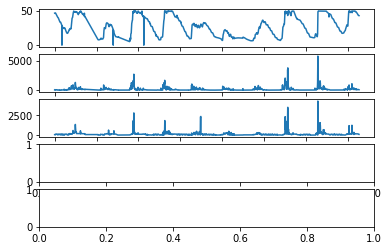

In [415]:
#all seems ok. still plotting to see
if DAM=='krs':
    fig,axs=plt.subplots(5)
    axs[0].plot(inputs['storage'])
    axs[1].plot(inputs['observed inflow'])
    axs[2].plot(inputs['observed outflow'])
    #axs[3].plot(inputs['simulated inflow'])
    #axs[4].plot(inputs['simulated outflow'])
    #axs[5].plot(inputs['simulated evapotranspiration'])
    #axs[4].plot(inputs['simulated storage'])
    #axs[7].plot(inputs['precipitation'])
else:
    fig,axs=plt.subplots(5)
    axs[0].plot(inputs['storage'])
    axs[1].plot(inputs['observed inflow'])
    #axs[2].plot(inputs['observed outflow'])
    #axs[3].plot(inputs['simulated inflow'])
  #  axs[4].plot(inputs['simulated outflow'])
    #axs[5].plot(inputs['simulated evapotranspiration'])
    #axs[4].plot(inputs['simulated storage'])
    #axs[7].plot(inputs['precipitation'])

In [416]:
#How to handle missing values in time-series data with strong seasonality?
# 1. simply remove the data
# 2. data imputation (method depends on keeping in mind the seasonality)

# For quick testing: https://www.kaggle.com/juejuewang/handle-missing-values-in-time-series-for-beginners
# for understanding: https://www.nature.com/articles/s41598-018-24271-9

In [417]:
###plt.plot(inputs['date'], inputs['storage'])

# most missing values are in a continuous range. So simply omitting for now
#my (untested) assumption is that if we simply omit these values, there are only 2-3 places where our network will perform bad. These will be ignored in a model that does not overfit

In [418]:
# fig, axs=plt.subplots()
# axs.plot(inputs['date'], inputs['storage'], color='red')
# axs2=axs.twinx() #data had different range. so plotted on separate y-axes
# axs2.plot(inputs['date'], inputs['outflow'], color='blue')
# plt.show()

In [419]:
# #Method 1: removing missing values
# inputs=inputs.dropna()
# inputs.info()

In [420]:
# plt.plot(inputs['date'], inputs['storage'])

In [421]:
# #ETS (Error- Trend - Seasonality)
# from statsmodels.tsa.seasonal import seasonal_decompose
# # ETS Decomposition of storage and date
# subset=inputs[['storage', 'date']]
# subset=subset.set_index('date')
# subset=subset.asfreq('D')

# result = seasonal_decompose(subset['storage'], 
#                             model ='additive')
  
# # ETS plot 
# result.plot()

# Setting up for models

In [422]:
inputs

,storage,observed inflow,observed outflow,outflow hemavathi,day,month,year,Month cos
0,46.42,57.46128,56.64000,56.66832,1,1,2011,0.866025
1,46.54,87.33888,42.19680,55.22400,2,1,2011,0.866025
2,46.64,78.61632,42.22512,55.22400,3,1,2011,0.866025
3,46.69,65.44752,42.22512,30.44400,4,1,2011,0.866025
4,46.70,52.30704,42.22512,15.57600,5,1,2011,0.866025
...,...,...,...,...,...,...,...,...
3633,43.04,99.00672,93.68256,126.02400,12,12,2020,1.000000
3634,43.02,90.53904,93.45600,124.60800,13,12,2020,1.000000
3635,42.98,85.69632,92.69136,124.60800,14,12,2020,1.000000
3636,42.92,71.64960,86.88576,123.75840,15,12,2020,1.000000


In [423]:
#setup based on https://www.tensorflow.org/tutorials/structured_data/time_series
df=inputs

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

#split data 70%-20%-10% (train-validation-test). Since this is time-series data, please don't shuffle.
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
#test_df=df[int(n*0.9):]
test_df=df[int(n*0.9)-INPUT_WIDTH:]#Not a data corruption. Only inputs are from valset, not the outputs. 
#We do it for a fair compare among different models, who otherwise may or may not see seasonal spikes

num_features = df.shape[1]

In [424]:
len(test_df),len(val_df)

(449, 658)

In [425]:
test_df

,storage,observed inflow,observed outflow,outflow hemavathi,day,month,year,Month cos
3164,49.45,247.51680,242.10768,126.0240,31,8,2019,-5.000000e-01
3165,49.45,248.53632,243.52368,126.7320,1,9,2019,-1.836970e-16
3166,49.45,249.44256,243.52368,128.8560,2,9,2019,-1.836970e-16
3167,49.45,249.44256,243.52368,131.6880,3,9,2019,-1.836970e-16
3168,49.45,347.91120,341.99232,355.4160,4,9,2019,-1.836970e-16
...,...,...,...,...,...,...,...,...
3633,43.04,99.00672,93.68256,126.0240,12,12,2020,1.000000e+00
3634,43.02,90.53904,93.45600,124.6080,13,12,2020,1.000000e+00
3635,42.98,85.69632,92.69136,124.6080,14,12,2020,1.000000e+00
3636,42.92,71.64960,86.88576,123.7584,15,12,2020,1.000000e+00


In [426]:
#normalize
#To-do: Change this. Instead use a preprocessing layer in the network itself. So that new input (which is not normalized) can be used straight away 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [427]:
print(pd.date_range(start="28-02-2020", end="16-12-2020").difference(test_df.index))

DatetimeIndex(['2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08',
               ...
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14',
               '2020-12-15', '2020-12-16'],
              dtype='datetime64[ns]', length=293, freq=None)


In [428]:
train_mean.shape, train_std.shape

((8,), (8,))

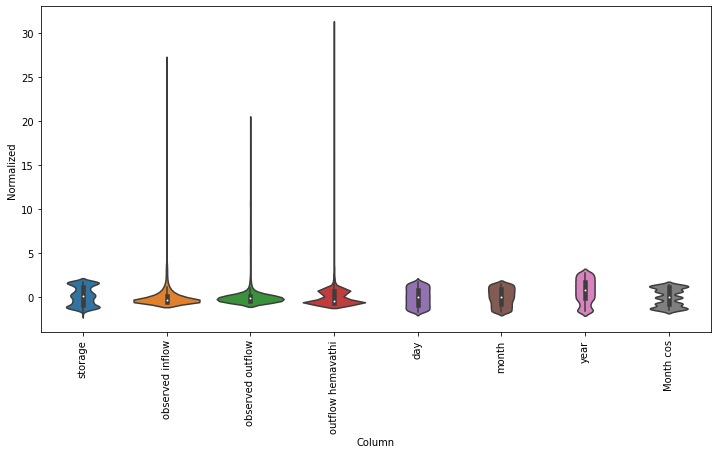

In [429]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
#Most data of inflow is concentrated, except seasonal peaks.

In [430]:
#Windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift #maybe we should change this for when we have many outputs

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [431]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                     label_columns=['storage'])
w1

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
Label column name(s): ['storage']

In [432]:
#split window into inputs and labels
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [433]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 150, 8)
Inputs shape: (3, 120, 8)
labels shape: (3, 90, 1)


In [434]:
w1.example = example_inputs, example_labels

In [435]:
def plot(self, model=None, plot_col='storage', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

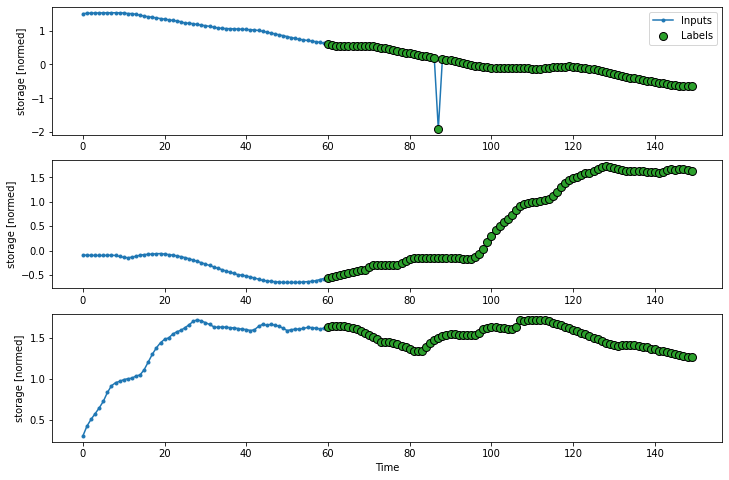

In [436]:
w1.plot()

In [437]:
## CROSS VALIDATION
from sklearn.model_selection import TimeSeriesSplit


tscv=TimeSeriesSplit(n_splits=3)
print(tscv)
train_df.shape, val_df.shape, test_df.shape

TimeSeriesSplit(max_train_size=None, n_splits=3)


((2301, 8), (658, 8), (449, 8))

In [438]:
class BlockingTimeSeriesSplit(): #better than sklearn time-series split (for preventing leakage of future data)
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]


In [439]:
def make_dataset(self, data, shuffle=True):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=BATCH_SIZE,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [440]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, shuffle=False) #important

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [441]:
w1.train.element_spec

(TensorSpec(shape=(None, 120, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 90, 1), dtype=tf.float32, name=None))

In [442]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (256, 120, 8)
Labels shape (batch, time, features): (256, 90, 1)


In [443]:
#wide_window and wide_conv_window is just for display purposes, it doesn't change the model
wide_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH_DISPLAY, shift=SHIFT,
    label_columns=['storage'])


for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

wide_window

Inputs shape (batch, time, features): (256, 120, 8)
Labels shape (batch, time, features): (256, 40, 1)


Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149]
Label column name(s): ['storage']

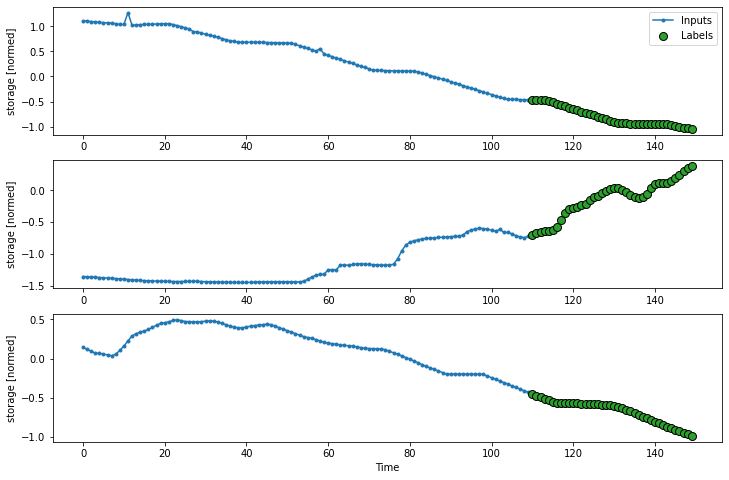

In [444]:
wide_window.plot()

In [445]:
conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=SHIFT,
    label_columns=['storage'])

conv_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
Label column name(s): ['storage']

In [446]:
INPUT_WIDTH, LABEL_WIDTH, SHIFT

(120, 90, 30)

In [447]:
#To-do: only for display. add plots for multiple outputs (wide window function)
print(LABEL_WIDTH_DISPLAY)
INPUT_WIDTH_NEW = LABEL_WIDTH_DISPLAY + (INPUT_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH_NEW,
    label_width=LABEL_WIDTH_DISPLAY,
    shift=SHIFT,
    label_columns=['storage'])

wide_conv_window

40


Total window size: 189
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158]
Label indices: [149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188]
Label column name(s): ['storage']

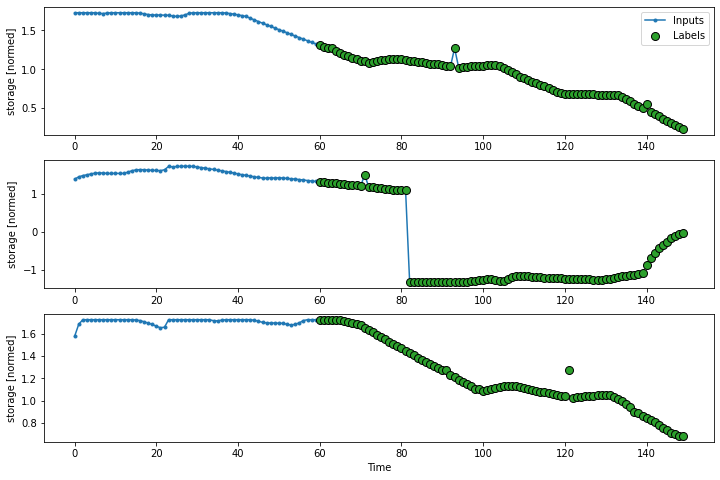

In [448]:
conv_window.plot()

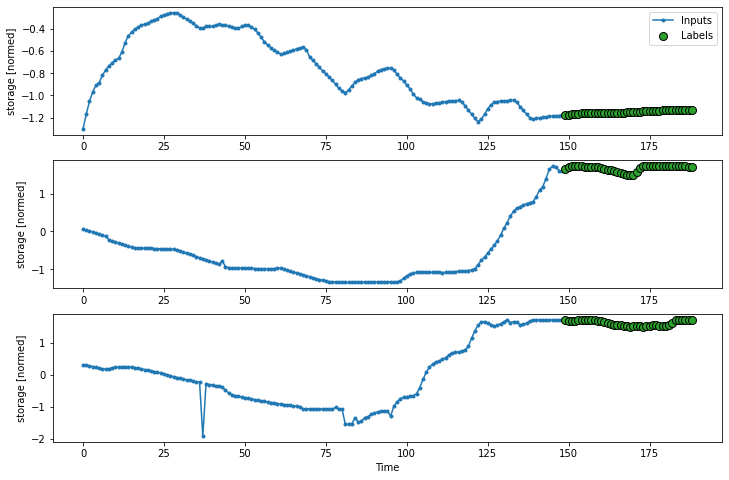

In [449]:
wide_conv_window.plot()

In [450]:
#to-do: build a baseline model (maybe simple auto-regressive model)
# build simpler models: linear, ARIMA, ...

# Model Setting and Learning Rate Optimization

In [451]:
#LR-Finder (adopted from fast.ai)
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-8, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

lr_finder=LRFinder()

In [452]:
#power scheduling learning rate. Didn't implement.

## Nash Sutcliffe Loss

In [453]:
#Nash Sutcliffe Efficiency Loss: https://github.com/thouska/spotpy/blob/master/spotpy/objectivefunctions.py
def nashsutcliffe(evaluation, simulation):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(evaluation) == len(simulation):
        s, e = np.array(simulation), np.array(evaluation)
        # s,e=simulation,evaluation
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return 1 - (numerator / denominator)

    else:
        logging.warning("evaluation and simulation lists does not have the same length.")
        return np.nan

In [454]:
import keras.backend as kb
import tensorflow.experimental
def nashsutcliffe_loss(evaluation, simulation):
    if len(evaluation) == len(simulation):
        #s, e = np.array(simulation), np.array(evaluation)
        s,e=simulation,evaluation
        mean_observed = tf.experimental.numpy.nanmean(e)
        # compute numerator and denominator
        numerator = tf.experimental.numpy.nansum((e - s) ** 2)
        denominator = tf.experimental.numpy.nansum((e - mean_observed)**2)
        # compute coefficient
        ratio= 1 - (numerator / denominator)
        return -1/(2-ratio)

    else:
        #logging.warning("evaluation and simulation lists does not have the same length.")
        return np.nan

# def nashsutcliffe_loss():
#     loss= nashsutcliffe(evaluation, simulation)
#     return loss

## Model Definition

In [455]:
#common function for all models
#for testing. keep epochs low, patience low (eg 50, 5). whent training keep high (eg. 5000, 15)
#MAX_EPOCHS = 30
#PATIENCE = 5 # stops training if overfitting. dont set it too low.

val_performance = {}
performance = {}
def compile_and_fit(model, window, patience=PATIENCE, is_earlystopping=False, is_lr_finder=False, is_cyclic_lr=True, max_epochs=MAX_EPOCHS):
  
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')
    
    if is_cyclic_lr:
        model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=clr),
                metrics=[#tf.metrics.MeanAbsolutePercentageError(),
                         tf.metrics.RootMeanSquaredError(),
                         tf.metrics.MeanAbsoluteError(), 
                         nashsutcliffe_loss, 
                         ])
    else:
         model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), 
                         #tf.metrics.MeanAbsolutePercentageError(), 
                         tf.metrics.RootMeanSquaredError()])   
    
    callbacks=[]
    if is_lr_finder:
        if is_earlystopping:
            callbacks=[early_stopping, lr_finder]
        else:
            callbacks=[lr_finder]    
    
    if is_earlystopping:
        callbacks=[early_stopping]


    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=callbacks)
    return history

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [456]:
len(train_df)/32, conv_window

(71.90625, Total window size: 150
 Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119]
 Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
   78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
   96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
  114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
  132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
 Label column name(s): ['storage'])

Epoch 1/500
9/9 [==============================] - 9s 137ms/step - loss: 1.1545 - mean_absolute_error: 0.8665 - root_mean_squared_error: 1.0092 - val_loss: 1.6371 - val_mean_absolute_error: 1.1068 - val_root_mean_squared_error: 1.2252
Epoch 2/500
9/9 [==============================] - 0s 28ms/step - loss: 1.1545 - mean_absolute_error: 0.8664 - root_mean_squared_error: 1.0092 - val_loss: 1.6371 - val_mean_absolute_error: 1.1068 - val_root_mean_squared_error: 1.2252
Epoch 3/500
9/9 [==============================] - 0s 29ms/step - loss: 1.1545 - mean_absolute_error: 0.8664 - root_mean_squared_error: 1.0092 - val_loss: 1.6370 - val_mean_absolute_error: 1.1068 - val_root_mean_squared_error: 1.2252
Epoch 4/500
9/9 [==============================] - 0s 27ms/step - loss: 1.1544 - mean_absolute_error: 0.8664 - root_mean_squared_error: 1.0092 - val_loss: 1.6369 - val_mean_absolute_error: 1.1068 - val_root_mean_squared_error: 1.2252
Epoch 5/500
9/9 [==============================] - 0s 27ms/step

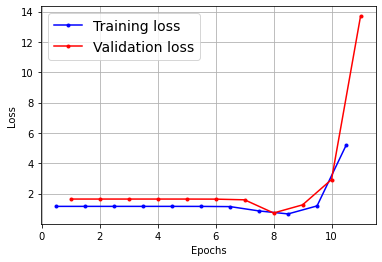

In [457]:
# This model is only for testing learning rate
#DROPOUT=0.3
#RECURRENT_DROPOUT=0.3

# we change optimizer in compiler function to remove learning_rate=clr
lstm_cyclic_lr = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

history = compile_and_fit(lstm_cyclic_lr, conv_window, is_earlystopping=False, is_lr_finder=True, 
                          is_cyclic_lr=False)    


#IPython.display.clear_output()
plot_learning_curves(history.history['loss'], history.history['val_loss'])

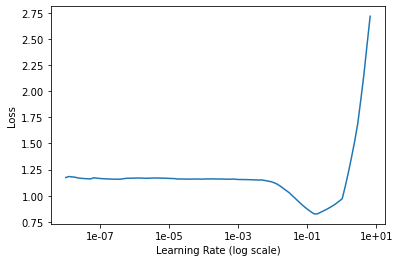

In [458]:
lr_finder.plot()

In [459]:
#Cyclic Learning Rate
!pip install tensorflow_addons
import tensorflow_addons as tfa
import math
MAX_LR=0.01 #from lr_finder graph. 1 order less than minima
MIN_LR=.002 # from lr_finder graph. 1/5th of max_lr
#BATCH_SIZE=32
STEPS_PER_EPOCH=math.ceil(len(train_df)/BATCH_SIZE)#

def scale_fn(x):
    return 1/(2.**(x-1))

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=MIN_LR,maximal_learning_rate=MAX_LR,
                                          scale_fn=scale_fn,
                                          step_size=2 * STEPS_PER_EPOCH
)

#It is usually used with SGD optimizer, but we are using with ADAM

In [460]:
# step = np.arange(0,MAX_EPOCHS * 200)
# lr = clr(step)
# plt.plot(step, lr)
# plt.xlabel("Steps")
# plt.ylabel("Learning Rate")
# plt.show()


#Final Model and Ensemble (Monte-Carlo Dropout)

In [461]:
tf.random.set_seed(42) #For reproducibility
np.random.seed(42)

In [462]:
# Deterministic Model

if (LABEL_WIDTH==30) : # We prefer a simpler model for long-timeseries.
    lstm_no_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
 #   Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

else:
    lstm_no_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
 #   Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

# we change optimizer in compiler function to remove learning_rate=clr
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_no_mc(conv_window.example[0]).shape)

history = compile_and_fit(lstm_no_mc, conv_window, max_epochs=20)    
IPython.display.clear_output()

In [463]:
#lstm_no_mc.summary()

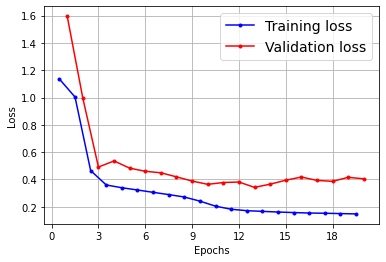

In [464]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [465]:
conv_window.train, conv_window.val, conv_window.test

(<MapDataset shapes: ((None, 120, 8), (None, 90, 1)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((None, 120, 8), (None, 90, 1)), types: (tf.float32, tf.float32)>,
 <MapDataset shapes: ((None, 120, 8), (None, 90, 1)), types: (tf.float32, tf.float32)>)

In [466]:
class MonteCarloLSTM(tf.keras.layers.LSTM):
   def call(self, inputs):
      return super().call(inputs, training=True)

In [467]:
## FINAL ENSEMBLE MODEL
#if (INPUT_WIDTH>=300):
if LABEL_WIDTH==30:
    lstm_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    MonteCarloLSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH, kernel_initializer=tf.initializers.zeros())),
    tf.keras.layers.Reshape([-1,1])
])
else:
    lstm_mc = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    MonteCarloLSTM(units=32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    MonteCarloLSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    MonteCarloLSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(l1_reg, l2_reg)),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])



print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_mc(conv_window.example[0]).shape)

history = compile_and_fit(lstm_mc, conv_window, max_epochs=500, patience=40, is_earlystopping=True)
IPython.display.clear_output()

krs 120 90 0.0001 0.0001 256


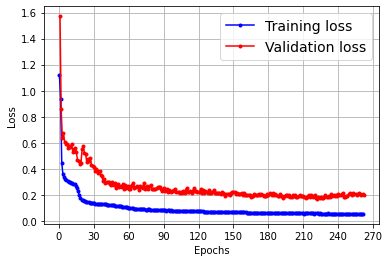

In [468]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


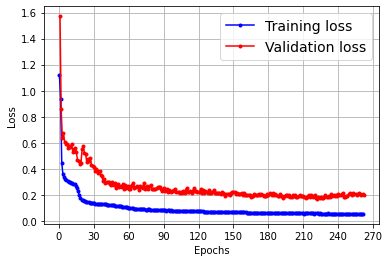

In [469]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


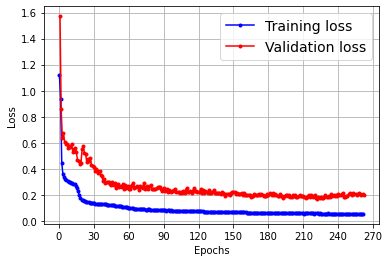

In [470]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


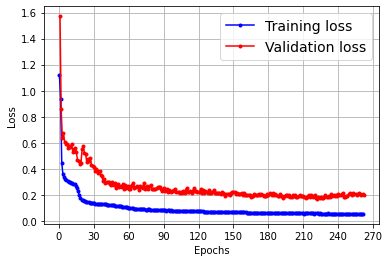

In [471]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


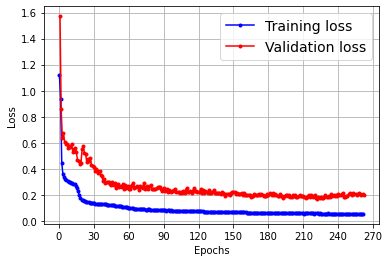

In [472]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


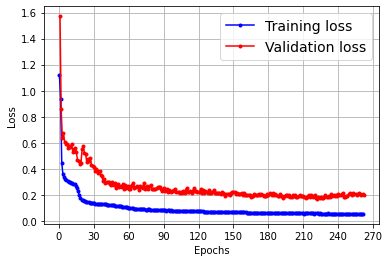

In [473]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


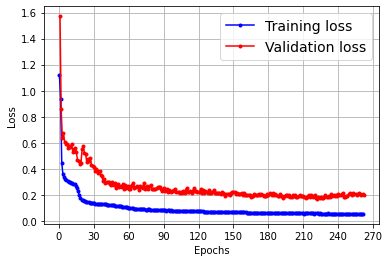

In [474]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


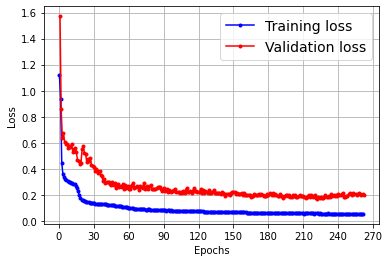

In [475]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


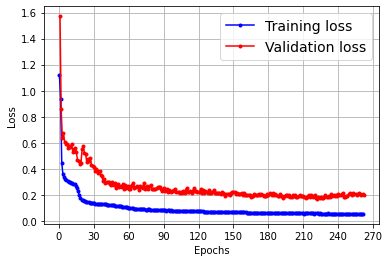

In [476]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


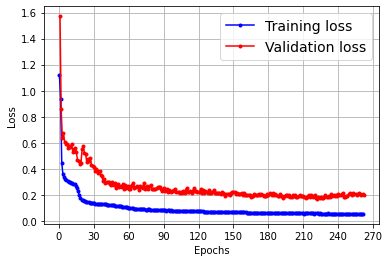

In [477]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


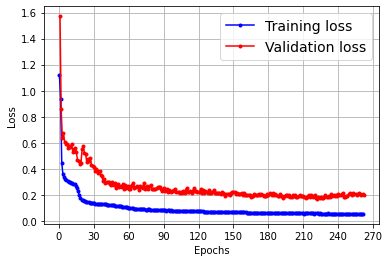

In [478]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

krs 120 90 0.0001 0.0001 256


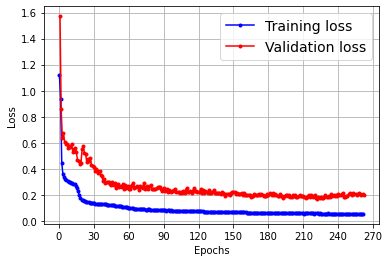

In [479]:
print(DAM, INPUT_WIDTH, LABEL_WIDTH, l1_reg, l2_reg, BATCH_SIZE)
plot_learning_curves(history.history['loss'], history.history['val_loss']) 

## Save model

In [480]:
#lstm_mc.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc')
#lstm_mc.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc_nseloss')
lstm_mc.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc_rmseloss')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/krs_120_90_lstm_mc_rmseloss/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/krs_120_90_lstm_mc_rmseloss/assets


# Saving Predictions

In [481]:
class MonteCarloLSTM(tf.keras.layers.LSTM):
   def call(self, inputs):
      return super().call(inputs, training=True)

In [482]:
#model_list=['dense_nn', 'lstm_basic','wavenet','lstm_deep_1', 'lstm_deep_2', 'lstm_deep_3'] #SINGLE PREDICTIONS

model_list=[f'{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc'] #ENSEMBLE PREDICTIONS
model_list=[f'{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc_nseloss'] #ENSEMBLE PREDICTIONS
model_list=[f'{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_lstm_mc_rmseloss'] #ENSEMBLE PREDICTIONS
#Run everything except models block to run this block. (Run Learning Rate Optimizers as well)
model_list

['krs_120_90_lstm_mc_rmseloss']

In [483]:
#FOR ENSEMBLE PREDICTIONS
ENSEMBLE_SIZE=50

labels_f=[]
inputs_f=[]
predictions_f=[] 

for models in model_list:
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{models}',
                                     custom_objects={"scale_fn": scale_fn, 'MonteCarloLSTM': MonteCarloLSTM, 'nashsutcliffe_loss': nashsutcliffe_loss})
    
    for j in range(ENSEMBLE_SIZE):
        predictions=model.predict(conv_window.test)
        predictions=predictions*train_std[0]+train_mean[0] #unnormalize
        predictions_f.append(predictions)
    predictions_f=np.array(predictions_f)

    i=0
    for inputs, labels in conv_window.test.take(-1):

    #print(inputs.shape, labels.shape, i)
        if i==0:
            inputs_f=inputs
            labels_f=labels
        else:
            inputs_f=tf.concat([inputs_f, inputs], axis=0)
            labels_f=tf.concat([labels_f, labels], axis=0)
        i +=1

    #un-normalize
    labels_f=labels_f*train_std[0]+train_mean[0]
    inputs_f=inputs_f*train_std+train_mean

    #mean and variance
    predictions_mean=predictions_f.mean(axis=0)
    predictions_std=predictions_f.std(axis=0)

In [484]:
predictions_f.shape, predictions_mean.shape, labels_f.shape

((50, 300, 90, 1), (300, 90, 1), TensorShape([300, 90, 1]))

In [485]:
#model.get_config(), model.summary()
conv_window.test

<MapDataset shapes: ((None, 120, 8), (None, 90, 1)), types: (tf.float32, tf.float32)>

In [486]:
inputs_f=inputs_f.numpy()
labels_f=labels_f.numpy()

day_index=conv_window.column_indices['day']
month_index=conv_window.column_indices['month']
year_index=conv_window.column_indices['year']
print(day_index, month_index, year_index)

from datetime import datetime, timedelta
BATCH_SIZE=predictions_mean.shape[0]
date_f=[]
print(BATCH_SIZE)
for i in range(BATCH_SIZE): #for each batch i
    for j in range(LABEL_WIDTH): #LABEL_WIDTH
        #print(i)
        #input_start_date=datetime(year=round(inputs_f[i][0][year_index]), month=round(inputs_f[i][0][month_index]), day=round(inputs_f[i][0][day_index]))
        input_end_date=datetime(year=round(inputs_f[i][-1][year_index]), month=round(inputs_f[i][-1][month_index]), day=round(inputs_f[i][-1][day_index]))
        pred_date=input_end_date+timedelta(days=j+1)
        #pred_start_date=input_end_date+timedelta(days=1)
        #pred_end_date=input_end_date+timedelta(days=LABEL_WIDTH)
        date_f.append(pred_date)
        #print(pred_date)
        #print(input_start_date, input_end_date, pred_start_date, pred_end_date, pred_date)
date_f=np.array(date_f)
date_f=np.reshape(date_f, newshape=(BATCH_SIZE, LABEL_WIDTH, 1))
print(date_f.shape)
print(date_f[0:2, :, :])
print(date_f[:-1, :, :])


4 5 6
300
(300, 90, 1)
[[[datetime.datetime(2019, 12, 31, 0, 0)]
  [datetime.datetime(2020, 1, 1, 0, 0)]
  [datetime.datetime(2020, 1, 2, 0, 0)]
  [datetime.datetime(2020, 1, 3, 0, 0)]
  [datetime.datetime(2020, 1, 4, 0, 0)]
  [datetime.datetime(2020, 1, 5, 0, 0)]
  [datetime.datetime(2020, 1, 6, 0, 0)]
  [datetime.datetime(2020, 1, 7, 0, 0)]
  [datetime.datetime(2020, 1, 8, 0, 0)]
  [datetime.datetime(2020, 1, 9, 0, 0)]
  [datetime.datetime(2020, 1, 10, 0, 0)]
  [datetime.datetime(2020, 1, 11, 0, 0)]
  [datetime.datetime(2020, 1, 12, 0, 0)]
  [datetime.datetime(2020, 1, 13, 0, 0)]
  [datetime.datetime(2020, 1, 14, 0, 0)]
  [datetime.datetime(2020, 1, 15, 0, 0)]
  [datetime.datetime(2020, 1, 16, 0, 0)]
  [datetime.datetime(2020, 1, 17, 0, 0)]
  [datetime.datetime(2020, 1, 18, 0, 0)]
  [datetime.datetime(2020, 1, 19, 0, 0)]
  [datetime.datetime(2020, 1, 20, 0, 0)]
  [datetime.datetime(2020, 1, 21, 0, 0)]
  [datetime.datetime(2020, 1, 22, 0, 0)]
  [datetime.datetime(2020, 1, 23, 0, 0)]
 

In [487]:
print(labels_f.shape, predictions_mean.shape, predictions_std.shape, date_f.shape) #all should be same

(300, 90, 1) (300, 90, 1) (300, 90, 1) (300, 90, 1)


In [488]:
#Saving
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels',labels_f)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean',predictions_mean)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_std',predictions_std)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_dates',date_f)

# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels_nseloss',labels_f)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean_nseloss',predictions_mean)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_std_nseloss',predictions_std)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_dates_nseloss',date_f)

np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels_rmseloss',labels_f)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean_rmseloss',predictions_mean)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_std_rmseloss',predictions_std)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_dates_rmseloss',date_f)



In [489]:
INPUT_WIDTH, LABEL_WIDTH, DAM

(120, 90, 'krs')

In [490]:
#FUTURE PREDICTIONS
input_array=test_df.to_numpy()
a=input_array.shape[0]
input_array=input_array[a-INPUT_WIDTH:]
b=input_array.shape
input_array=input_array.reshape((1,b[0],b[1]))

predictions_future_f=[]
for j in range(ENSEMBLE_SIZE):
    predictions=model.predict(input_array)
    predictions=predictions*train_std[0]+train_mean[0] #unnormalize
    predictions_future_f.append(predictions)
predictions_future_f=np.array(predictions_future_f)


future_date_f=[]
for j in range(LABEL_WIDTH): #LABEL_WIDTH
        pred_date=LAST_DATE+timedelta(days=j+1)
        future_date_f.append(pred_date)

#mean and variance
predictions_future_mean=predictions_future_f.mean(axis=0)
predictions_future_std=predictions_future_f.std(axis=0)

# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_mean',predictions_future_mean)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_std',predictions_future_std)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_prediction_dates',future_date_f)

# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_mean_nseloss',predictions_future_mean)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_std_nseloss',predictions_future_std)
# np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_prediction_dates_nseloss',future_date_f)

np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_mean_rmseloss',predictions_future_mean)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_predictions_std_rmseloss',predictions_future_std)
np.save(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_future_prediction_dates_rmseloss',future_date_f)


print(predictions_future_mean.shape, future_date_f)

(1, 90, 1) [datetime.datetime(2020, 12, 17, 0, 0), datetime.datetime(2020, 12, 18, 0, 0), datetime.datetime(2020, 12, 19, 0, 0), datetime.datetime(2020, 12, 20, 0, 0), datetime.datetime(2020, 12, 21, 0, 0), datetime.datetime(2020, 12, 22, 0, 0), datetime.datetime(2020, 12, 23, 0, 0), datetime.datetime(2020, 12, 24, 0, 0), datetime.datetime(2020, 12, 25, 0, 0), datetime.datetime(2020, 12, 26, 0, 0), datetime.datetime(2020, 12, 27, 0, 0), datetime.datetime(2020, 12, 28, 0, 0), datetime.datetime(2020, 12, 29, 0, 0), datetime.datetime(2020, 12, 30, 0, 0), datetime.datetime(2020, 12, 31, 0, 0), datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2021, 1, 2, 0, 0), datetime.datetime(2021, 1, 3, 0, 0), datetime.datetime(2021, 1, 4, 0, 0), datetime.datetime(2021, 1, 5, 0, 0), datetime.datetime(2021, 1, 6, 0, 0), datetime.datetime(2021, 1, 7, 0, 0), datetime.datetime(2021, 1, 8, 0, 0), datetime.datetime(2021, 1, 9, 0, 0), datetime.datetime(2021, 1, 10, 0, 0), datetime.datetime(2021, 1, 11, 0

In [491]:
LAST_DATE

datetime.datetime(2020, 12, 16, 0, 0)

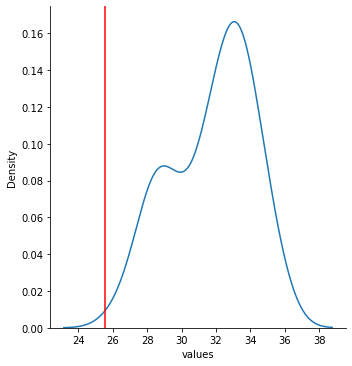

In [492]:
#How a sample looks like
predictions_f_no_mc=lstm_no_mc.predict(conv_window.test)
predictions_f_no_mc=predictions_f_no_mc*train_std[0]+train_mean[0]

import matplotlib.pyplot as plt
g= sns.displot(data=predictions_f[:,10,-1,0], kind='kde')
g = g.set_axis_labels("values","Density")

#set(xlim=(275,295),ylim=(0,1)))
plt.axvline(predictions_f_no_mc[10,-1,0], c='r')
#plt.axvline(valid_diff.t.sel(time='2017-01-04T12').isel(lat=16, lon=0), c='r')
#plt.title("MC Dropout Forecast")
#plt.legend(('ensemble', 'truth'), loc='center left')
#plt.show()

In [493]:
print(predictions_f.shape, predictions_f[:,10,-1,0].shape)
print(predictions_f_no_mc[10,-1,0], predictions_f[:,10,-1,0])

(50, 300, 90, 1) (50,)
25.524382 [29.343102 33.3057   31.583626 33.34373  31.919819 32.03824  33.489414
 28.267752 31.640043 28.524029 26.411598 33.48029  31.684105 32.662235
 35.5028   28.513422 29.442545 31.806694 31.060276 33.35519  33.521996
 33.82795  32.5234   34.28021  28.61586  35.11337  32.72389  30.523373
 29.19411  33.1809   28.065323 34.47204  35.476437 28.217697 33.650288
 34.71852  31.263071 32.183487 30.506748 33.265724 33.429657 32.68934
 29.36509  27.46833  33.28009  34.0895   32.40518  27.923204 29.716516
 34.69857 ]


# Performance and Visualizations

In [396]:
# labels=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels.npy')
# predictions_mean=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean.npy')

# labels=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels_nseloss.npy')
# predictions_mean=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean_nseloss.npy')


# labels=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels_rmseloss.npy')
# predictions_mean=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean_rmseloss.npy')
DAM, INPUT_WIDTH, LABEL_WIDTH

('krs', 60, 30)

In [397]:
#for DAM in ('krs','kabini','hemavathi','harangi'):
 #   for INPUT_AND_LABEL_WIDTH in ('90_30', '120_60', '120_90'):
    #    labels=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_AND_LABEL_WIDTH}_labels_rmseloss.npy')
    #    predictions_mean=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_AND_LABEL_WIDTH}_predictions_mean_rmseloss.npy')
        
    #    mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
     #   print(DAM, INPUT_AND_LABEL_WIDTH, mse.numpy().mean(), labels.shape, predictions_mean.shape) #rmse loss 120 days. l2 0.001



labels=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_labels_rmseloss.npy')
predictions_mean=np.load(f'predictions_multi_timestep/{DAM}_{INPUT_WIDTH}_{LABEL_WIDTH}_predictions_mean_rmseloss.npy')
mse=tf.keras.metrics.mean_squared_error(labels, predictions_mean)
print(DAM, INPUT_AND_LABEL_WIDTH, mse.numpy().mean(), labels.shape, predictions_mean.shape) #rmse loss 120 days. l2 0.001

#labels.shape, predictions_mean.shape

krs 60_30 101.427734 (300, 30, 1) (300, 30, 1)


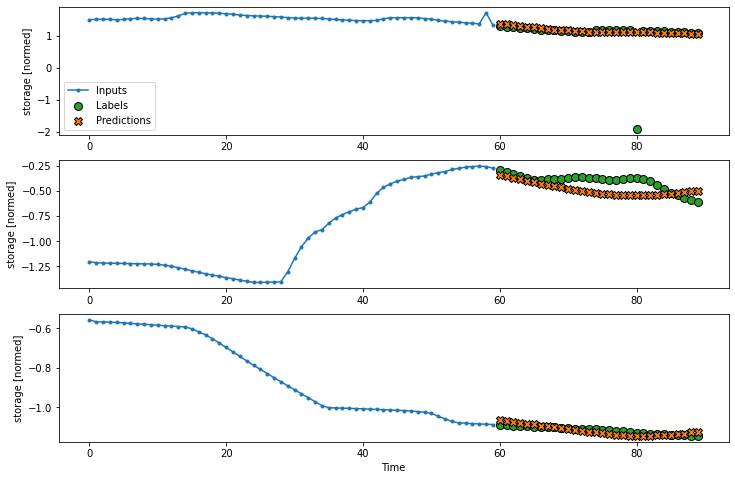

In [398]:
#Plot Predictions
conv_window.plot(lstm_mc) #hemavathi

In [ ]:
# x = np.arange(len(performance))
# width = 0.3

# metric_name = 'mean_absolute_percentage_error'
# metric_index = lstm_deep_2.metrics_names.index('mean_absolute_percentage_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# plt.ylabel('MAPE (average over all outputs)')
# _ = plt.legend()

In [ ]:
# x = np.arange(len(performance))
# width = 0.3

# metric_name = 'root_mean_squared_error'
# metric_index = lstm_deep_2.metrics_names.index('root_mean_squared_error')
# val_mae = [v[metric_index] for v in val_performance.values()]
# test_mae = [v[metric_index] for v in performance.values()]

# plt.bar(x - 0.17, val_mae, width, label='Validation')
# plt.bar(x + 0.17, test_mae, width, label='Test')
# plt.xticks(ticks=x, labels=performance.keys(),
#            rotation=45)
# plt.ylabel('RMSE (average over all outputs)')
# _ = plt.legend()

# Model Experimentation (Ignore)

In [ ]:
# # Model 0: ARIMA
# #!pip install pmdarima
# from pmdarima import auto_arima
  
# # Ignore harmless warnings
# import warnings
# warnings.filterwarnings("ignore")
  
# # Fit auto_arima function to AirPassengers dataset
# stepwise_fit = auto_arima(inputs['storage'], start_p = 1, start_q = 1,
#                           max_p = 3, max_q = 3, m = 12,
#                           start_P = 0, seasonal = True,
#                           d = None, D = 1, trace = True,
#                           error_action ='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings = True,  # we don't want convergence warnings
#                           stepwise = True)           # set to stepwise
  
# # To print the summary
# stepwise_fit.summary()


Best model:  ARIMA(2,0,0)(2,1,0)[12]          
Total fit time: 378.848 seconds

SARIMAX Results Dep. Variable: 	y 	No. Observations: 	3306
Model: 	SARIMAX(2, 0, 0)x(2, 1, 0, 12) 	Log Likelihood 	-6571.364
Date: 	Sat, 17 Jul 2021 	AIC 	13152.729
Time: 	04:08:47 	BIC 	13183.228
Sample: 	0 	HQIC 	13163.647
	- 3306 		
Covariance Type: 	opg 		
	coef 	std err 	z 	P>|z| 	[0.025 	0.975]
ar.L1 	0.6936 	0.002 	326.821 	0.000 	0.689 	0.698
ar.L2 	0.2822 	0.004 	72.697 	0.000 	0.275 	0.290
ar.S.L12 	-0.6670 	0.003 	-210.457 	0.000 	-0.673 	-0.661
ar.S.L24 	-0.3176 	0.003 	-98.993 	0.000 	-0.324 	-0.311
sigma2 	3.1570 	0.008 	381.105 	0.000 	3.141 	3.173
Ljung-Box (L1) (Q): 	0.12 	Jarque-Bera (JB): 	5238207.52
Prob(Q): 	0.73 	Prob(JB): 	0.00
Heteroskedasticity (H): 	0.17 	Skew: 	-4.50
Prob(H) (two-sided): 	0.00 	Kurtosis: 	198.15


Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

In [ ]:
# Model 1: multi-step dense. (Fully-connected NN)
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#Model 2: Conv-dense. same model but more flexible for different input shapes.
#DROPOUT=0.3
dense_nn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(INPUT_WIDTH,),activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01) ),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)),
    tf.keras.layers.Dropout(rate=DROPOUT),
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])
])

In [ ]:
print("Dense model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', dense_nn(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(dense_nn, conv_window)

IPython.display.clear_output()
val_performance['dense_nn'] = dense_nn.evaluate(conv_window.val)
performance['dense_nn'] = dense_nn.evaluate(conv_window.test, verbose=0)

conv_window.plot(dense_nn)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#dense_nn.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_dense_nn')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/krs_1_dense_nn/assets


In [ ]:
#wide_conv_window.plot(dense_nn)

In [ ]:
# Model 3: Recurrent Neural Network - LSTM (Simple)
lstm_basic = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ),#model outputs all intermediate predictions as well. If training a deep network, need this for all layers except the last
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_basic(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)

Input shape: (32, 365, 11)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_basic, conv_window)

#IPython.display.clear_output()
#val_performance['lstm_basic'] = lstm_basic.evaluate(conv_window.val)
#performance['lstm_basic'] = lstm_basic.evaluate(conv_window.test, verbose=0)

Epoch 1/30
60/60 [==============================] - 4s 21ms/step - loss: 0.1852 - nashsutcliffe_loss: -0.9065 - val_loss: 1.4274 - val_nashsutcliffe_loss: -0.5610
Epoch 2/30
60/60 [==============================] - 1s 10ms/step - loss: 0.3838 - nashsutcliffe_loss: -0.8234 - val_loss: 1.2702 - val_nashsutcliffe_loss: -0.6278
Epoch 3/30
60/60 [==============================] - 1s 12ms/step - loss: 0.5090 - nashsutcliffe_loss: -0.8244 - val_loss: 1.9238 - val_nashsutcliffe_loss: -0.5053
Epoch 4/30
60/60 [==============================] - 1s 10ms/step - loss: 0.6014 - nashsutcliffe_loss: -0.8010 - val_loss: 1.8847 - val_nashsutcliffe_loss: -0.5125
Epoch 5/30
60/60 [==============================] - 1s 11ms/step - loss: 0.5542 - nashsutcliffe_loss: -0.8472 - val_loss: 1.6458 - val_nashsutcliffe_loss: -0.5646
Epoch 6/30
60/60 [==============================] - 1s 10ms/step - loss: 0.5265 - nashsutcliffe_loss: -0.8556 - val_loss: 1.6016 - val_nashsutcliffe_loss: -0.5725
Epoch 7/30
60/60 [====

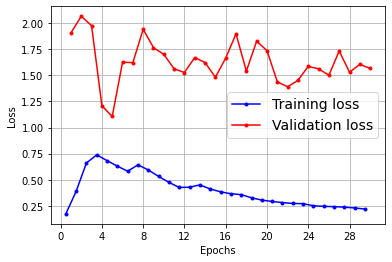

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

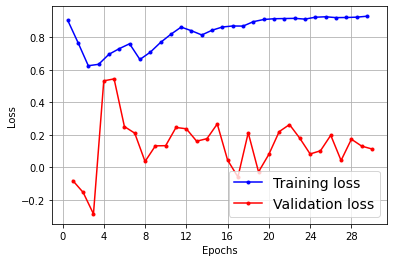

In [ ]:
plot_learning_curves(history.history['nashsutcliffe_loss'], history.history['val_nashsutcliffe_loss'])

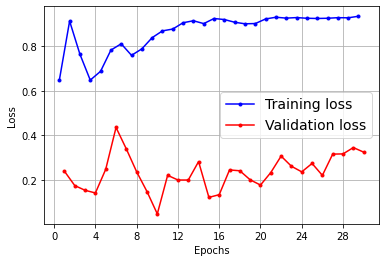

In [ ]:
plot_learning_curves(history.history['nashsutcliffe_loss'], history.history['val_nashsutcliffe_loss'])

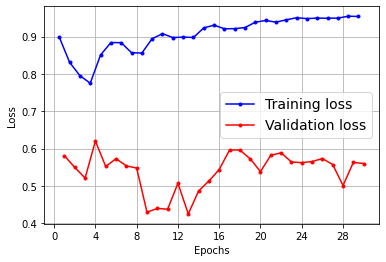

In [ ]:
plot_learning_curves(history.history['nashsutcliffe_loss'], history.history['val_nashsutcliffe_loss'])

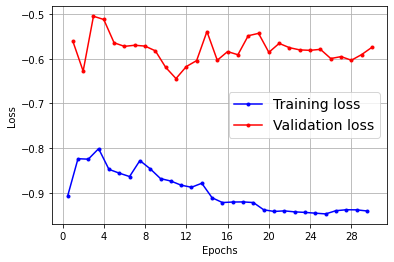

In [ ]:
plot_learning_curves(history.history['nashsutcliffe_loss'], history.history['val_nashsutcliffe_loss'])

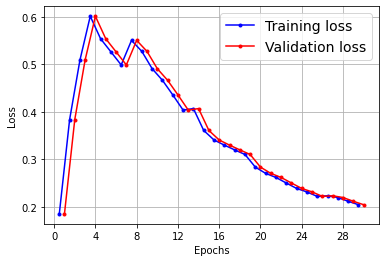

In [ ]:
plot_learning_curves(history.history['loss'], history.history['loss'])

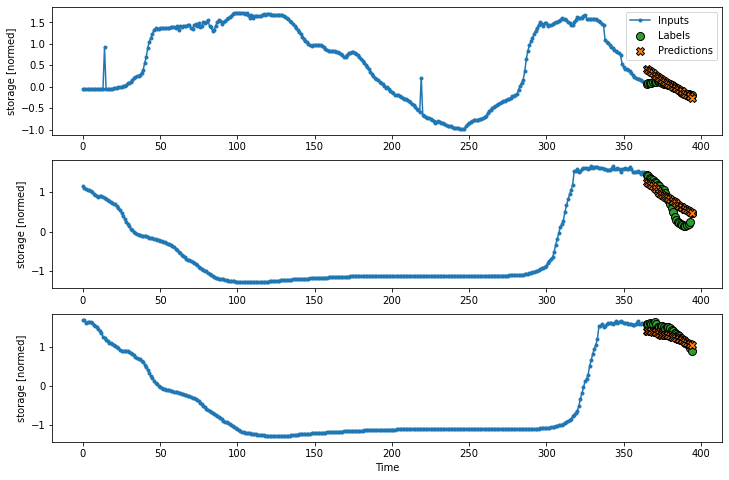

In [ ]:
conv_window.plot(lstm_basic)

In [ ]:
#lstm_basic.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_basic')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_basic/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/wave2web/models/krs_90_lstm_basic/assets


In [ ]:
# # Model 4: LSTM with Residual connections. (IMPLEMENTED WRONGLY> SKIP IT.)
# class ResidualWrapper(tf.keras.Model):
#   def __init__(self, model):
#     super().__init__()
#     self.model = model

#   def call(self, inputs, *args, **kwargs):
#     delta = self.model(inputs, *args, **kwargs)

#     # The prediction for each timestep is the input
#     # from the previous time step plus the delta
#     # calculated by the model.
#     return inputs + delta

In [ ]:
# residual_lstm = ResidualWrapper(
#     tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     tf.keras.layers.Dense(
#         num_features,
#         # The predicted deltas should start small
#         # So initialize the output layer with zeros
#         kernel_initializer=tf.initializers.zeros()),
#     tf.keras.layers.Dense(1)  #dont know if last layer should be added  
# ]))


In [ ]:
# print('Input shape:', conv_window.example[0].shape)
# print('Output shape:', residual_lstm(conv_window.example[0]).shape) #check output shape. should be (32, 1,1)


In [ ]:

# history = compile_and_fit(residual_lstm, conv_window)

# IPython.display.clear_output()
# val_performance['residual_lstm'] = residual_lstm.evaluate(conv_window.val)
# performance['residual_lstm'] = residual_lstm.evaluate(conv_window.test, verbose=0)

In [ ]:
# residual_lstm.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_residual_lstm')

In [ ]:
#take it deeper
#add layer norm
#add conv layer
#add dropout, recurrent_dropout. May also evaluate uncertainty using Monte-Carlo Dropout
#try WaveNet
#try bi-directional LSTM, GRU
#add cross-batch statefulness

In [ ]:
# Model 5: Deep LSTM
!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32) 


deep_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model(conv_window.example[0]).shape)
#expected (32, 1, 1). It is because of return_sequences=True and Conv1D

Input shape: (32, 365, 11)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(deep_lstm_model, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.val)
performance['Deep_LSTM'] = deep_lstm_model.evaluate(conv_window.test, verbose=0)

9/9 [==============================] - 0s 5ms/step - loss: 0.1943 - mean_absolute_error: 0.3171 - root_mean_squared_error: 0.4408


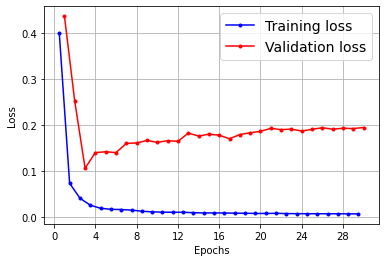

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
#Model 6: Deep LSTM with Conv; without Layer Normalization
deep_lstm_model_2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1, 1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', deep_lstm_model_2(conv_window.example[0]).shape)


In [ ]:
history = compile_and_fit(deep_lstm_model_2, conv_window)

IPython.display.clear_output()
val_performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.val)
performance['Deep_LSTM_2'] = deep_lstm_model_2.evaluate(wide_window.test, verbose=0)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Model 7: WaveNet
wavenet = tf.keras.models.Sequential()
wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=INPUT_WIDTH, strides=2, padding='valid'))
#wavenet.add(tf.keras.layers.InputLayer(input_shape=[None, 7]))# explicitly telling input shape. [None, #features]
for rate in (1, 2, 4, 8, 16, 32) * 2:
    wavenet.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001) ))
wavenet.add(tf.keras.layers.Conv1D(filters=10, kernel_size=1))
wavenet.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)))
wavenet.add(tf.keras.layers.Reshape([-1,1]))

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', wavenet(conv_window.example[0]).shape) #check shape. should be (32, 1, 1)

Input shape: (32, 120, 7)
Output shape: (32, 30, 1)


In [ ]:
#wavenet.summary()

In [ ]:
history = compile_and_fit(wavenet, conv_window)

IPython.display.clear_output()
val_performance['wavenet'] = wavenet.evaluate(conv_window.val)
performance['wavenet'] = wavenet.evaluate(conv_window.test, verbose=0)

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#wavenet.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_wavenet')

In [ ]:
# Model 8: LSTM with dropout (becasue all the above models seem to overfit)
# DROPOUT=0.5
# RECURRENT_DROPOUT=0.5

lstm_deep_1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    tf.keras.layers.LSTM(units=32, return_sequences=True, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT),
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_1(conv_window.example[0]).shape)


Input shape: (32, 365, 11)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_deep_1, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_1'] = lstm_deep_1.evaluate(conv_window.val)
performance['lstm_deep_1'] = lstm_deep_1.evaluate(conv_window.test, verbose=0)

9/9 [==============================] - 0s 3ms/step - loss: 0.6270 - mean_absolute_error: 0.4772 - root_mean_squared_error: 0.7919


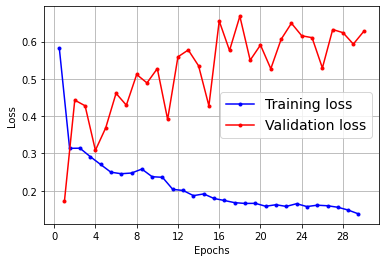

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#lstm_deep_1.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_deep_1')

In [ ]:
# Model 9: LSTM with dropout, conv, layer norm
# DROPOUT=0.3
# RECURRENT_DROPOUT=0.3
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)) 
lstm_deep_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True,  ),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True, ),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True, ),
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_2(conv_window.example[0]).shape)


Input shape: (32, 365, 11)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_deep_2, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_2'] = lstm_deep_2.evaluate(conv_window.val)
performance['lstm_deep_2'] = lstm_deep_2.evaluate(conv_window.test, verbose=0)

9/9 [==============================] - 0s 4ms/step - loss: 0.5288 - mean_absolute_error: 0.5450 - root_mean_squared_error: 0.7046


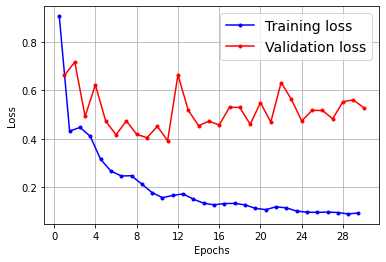

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#lstm_deep_2.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_deep_2')

In [ ]:
#wide_conv_window.plot(lstm_deep_2)

In [ ]:
# Model: Very Deep LSTM
# DROPOUT=0.3
# RECURRENT_DROPOUT=0.3
#!pip install tensorflow_addons
import tensorflow_addons as tfa
lnLSTMCell = tfa.rnn.LayerNormLSTMCell(units=32, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, 
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)) 
lstm_deep_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=INPUT_WIDTH, strides=2, padding='valid'),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    tf.keras.layers.RNN(lnLSTMCell, return_sequences=True),
    
    #If using Dense layer at the end (which you should), remove return_sequences=True from second last layer
    # Shape => [batch, time, features]
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=LABEL_WIDTH)),
    tf.keras.layers.Reshape([-1,1])
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', lstm_deep_3(conv_window.example[0]).shape)

Input shape: (32, 365, 11)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_deep_3, conv_window)

IPython.display.clear_output()
val_performance['lstm_deep_3'] = lstm_deep_3.evaluate(conv_window.val)
performance['lstm_deep_3'] = lstm_deep_3.evaluate(conv_window.test, verbose=0)

9/9 [==============================] - 0s 11ms/step - loss: 1.2882 - mean_absolute_error: 0.9873 - root_mean_squared_error: 1.1122


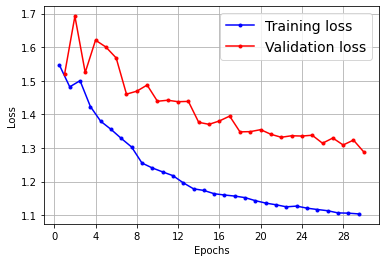

In [ ]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
#lstm_deep_3.save(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models_multi_timestep/{DAM}_{SHIFT}_lstm_deep_3')

# SHAP Values (Ignore)

In [ ]:
#getting truth_value
test_df3=[]
train_df3=[]
i=0
for _, labels in conv_window.test.take(-1):
    #print(inputs.shape, i)
    if i==0:
        test_df3=labels
    else:
        test_df3=tf.concat([test_df3, labels], axis=0)
    i +=1

i=0
for inputs, _ in conv_window.train.take(-1):
    #print(inputs.shape, i)
    if i==0:
        train_df3=inputs
    else:
        train_df3=tf.concat([train_df3, inputs], axis=0)
    i +=1


test_df3=test_df3.numpy()
train_df3=train_df3.numpy()
test_df3.shape, train_df3.shape #shap only accepts numpy array

((93, 1, 1), (1724, 90, 7))

In [ ]:
# #getting truth_value
# test_df3=[]
# train_df3=[]
# i=0
# for inputs, _ in conv_window.test.take(-1):
#     #print(inputs.shape, i)
#     if i==0:
#         test_df3=inputs
#     else:
#         test_df3=tf.concat([test_df3, inputs], axis=0)
#     i +=1

# i=0
# for inputs, _ in conv_window.train.take(-1):
#     #print(inputs.shape, i)
#     if i==0:
#         train_df3=inputs
#     else:
#         train_df3=tf.concat([train_df3, inputs], axis=0)
#     i +=1


# test_df3=test_df3.numpy()
# train_df3=train_df3.numpy()
# test_df3.shape, train_df3.shape #shap only accepts numpy array

((93, 90, 7), (1724, 90, 7))

In [ ]:
tf.compat.v1.disable_v2_behavior() #may cause MANY troubles, but sadly SHAP isn't fully compatible with Tensorflow 2.x.
#In general, run SHAP after you've done everything above. If you want to re-run codes with 2.x, do a factory reset runtime.

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
model_list=['lstm_deep_1']
for models in model_list:
    print(models)
    model=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_{models}',
                                     custom_objects={"scale_fn": scale_fn})
    model.add(tf.keras.layers.Reshape(target_shape=(1,))) #shap only accepts single number or vector


lstm_deep_1


In [ ]:
# preds=model.predict(conv_window.test)
# print(model.output_shape, preds.shape, train_df.shape, test_df.shape)
# #model.add(tf.keras.layers.Reshape(target_shape=(1,)))
# #preds=model.predict(conv_window.test)
# #model.output_shape, preds.shape, train_df.shape, test_df.shape
# type(model), type(test_df)
# #test_df2=test_df.to_numpy()
# #train_df2=train_df.to_numpy()
# #test_df2.shape, train_df2.shape
# #conv_window.train      #input,          output

In [ ]:
!pip install shap
import shap
explainer = shap.DeepExplainer(model, train_df3)
shap_values = explainer.shap_values(test_df3)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


ValueError: ignored

In [ ]:
explainer.expected_value, np.array(shap_values).shape, train_df.columns, train_df3.shape, test_df3.shape

(array([-0.1221296], dtype=float32),
 (1, 93, 90, 7),
 Index(['storage', 'inflow', 'outflow', 'rain', 'day', 'month', 'year'], dtype='object'),
 (1724, 90, 7),
 (93, 90, 7))

In [ ]:
#For a Single Prediction
shap.initjs() # init the JS visualization code. #in google colab, in every cell you need a visualization, you'll need to call initjs()
shap.force_plot(explainer.expected_value, shap_values[0][42][:][:], test_df3[42][:][:], train_df.columns)

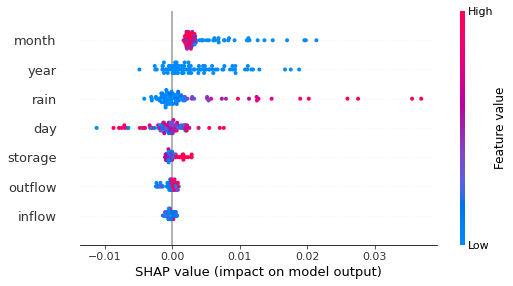

In [ ]:
shap.summary_plot(shap_values[0][:][10][:], test_df3[:][10][:], train_df.columns)

AttributeError: ignored

# Testing (Ignore)

In [ ]:
# dense_nn=tf.keras.models.load_model(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/models/{DAM}_{SHIFT}_dense_nn')

In [ ]:
predictions=lstm_no_mc.predict(conv_window.test)
predictions.shape

(232, 10, 1)

In [ ]:
predictions[0:2,0,0]

array([-0.5387033, -0.5540465], dtype=float32)

In [ ]:
conv_window.column_indices

{'day': 4,
 'inflow': 1,
 'month': 5,
 'outflow': 2,
 'rain': 3,
 'storage': 0,
 'year': 6}

In [ ]:
inputs_f=[]
labels_f=[]
i=0
for inputs, labels in conv_window.test.take(-1):

    print(inputs.shape, labels.shape, i)
    if i==0:
        inputs_f=inputs
        labels_f=labels
    else:
        inputs_f=tf.concat([inputs_f, inputs], axis=0)
        labels_f=tf.concat([labels_f, labels], axis=0)
    i +=1

(32, 40, 7) (32, 10, 1) 0
(32, 40, 7) (32, 10, 1) 1
(32, 40, 7) (32, 10, 1) 2
(32, 40, 7) (32, 10, 1) 3
(32, 40, 7) (32, 10, 1) 4
(32, 40, 7) (32, 10, 1) 5
(32, 40, 7) (32, 10, 1) 6
(8, 40, 7) (8, 10, 1) 7


In [ ]:
print(inputs_f.shape, labels_f.shape)
labels_f[0:5,0,0]

(232, 40, 7) (232, 10, 1)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.8167769 , -0.46505314,  1.7651813 ,  0.0908704 , -0.4497925 ],
      dtype=float32)>

In [ ]:
predictions=predictions*train_std[0]+train_mean[0]

In [ ]:
inputs_f=inputs_f*train_std+train_mean
labels_f=labels_f*train_std[0]+train_mean[0]
labels_f[0:5, 0, 0]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([49.34    , 49.449997, 20.939999, 25.25    , 19.61    ],
      dtype=float32)>

In [ ]:
labels_f[0:5, 0, 0], predictions[0:5, 0, 0]

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([49.34    , 49.449997, 20.939999, 25.25    , 19.61    ],
       dtype=float32)>,
 array([47.11271 , 46.98647 , 21.006842, 47.100323, 28.615885],
       dtype=float32))

In [ ]:
# labels_f=labels_f.numpy().reshape(-1)
# predictions=predictions.reshape(-1)
# labels_f.shape, predictions.shape

((183,), (183,))

In [ ]:
# !pwd

/content/gdrive/My Drive/Colab Notebooks/wave2web


In [ ]:
# df = pd.DataFrame({"true" : labels_f, "prediction" : predictions})
# df.to_csv(f'/content/gdrive/My Drive/Colab Notebooks/wave2web/predictions/{DAM}_{SHIFT}_dense_nn_predictions.csv', index=False)

In [ ]:
dates=tf.cast(inputs_f[:,:,4:7], dtype='int64')
dates[-1, :, :]

<tf.Tensor: shape=(40, 3), dtype=int64, numpy=
array([[  19,    5, 2020],
       [  20,    5, 2020],
       [  21,    5, 2020],
       [  22,    5, 2020],
       [  23,    5, 2020],
       [  24,    5, 2020],
       [  25,    5, 2020],
       [  26,    5, 2020],
       [  27,    5, 2020],
       [  28,    5, 2020],
       [  29,    5, 2020],
       [  30,    5, 2020],
       [  31,    5, 2020],
       [   1,    6, 2020],
       [   2,    6, 2020],
       [   3,    6, 2020],
       [   4,    6, 2020],
       [   5,    6, 2020],
       [   6,    6, 2020],
       [   7,    6, 2020],
       [   8,    6, 2020],
       [   9,    6, 2020],
       [  10,    6, 2020],
       [  11,    6, 2020],
       [  12,    6, 2020],
       [  13,    6, 2020],
       [  14,    6, 2020],
       [  15,    6, 2020],
       [  16,    6, 2020],
       [  17,    6, 2020],
       [  18,    6, 2020],
       [  19,    6, 2020],
       [  20,    6, 2020],
       [  21,    6, 2020],
       [  22,    6, 2020],
       [